# Load and visualize LSL data from Pico Neo 2 Eye 

In [15]:
import numpy as np
import pyxdf
import matplotlib as mpl
mpl.rcParams['animation.convert_path'] = 'magick'
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Load the data.

In [16]:
streams, header = pyxdf.load_xdf('test_pico_eeg.xdf')


for strm in streams:
    print(f"Found stream {strm['info']['name'][0]} ({strm['info']['type'][0]}) with data shape "
          f"{np.array(strm['time_series']).shape}")

stream_names = [strm['info']['name'][0] for strm in streams]
stream_types = [strm['info']['type'][0] for strm in streams]

Found stream UB-2015.05.10 (EEG) with data shape (23584, 31)
Found stream Unity.GameEvents (Markers) with data shape (60, 1)
Found stream Unity.TobiiGaze (Gaze) with data shape (2762, 12)
Found stream Unity.VRHeadPose (MoCap) with data shape (3305, 7)


## Get the gaze focus events

(TODO: Show them on a plot)

In [17]:
import json


marker_ix = stream_types.index('Markers')
marker_tvec = streams[marker_ix]['time_stamps']
focus_dat = np.zeros((3, len(marker_tvec)), dtype=np.int)

for ix, ev in enumerate(streams[marker_ix]['time_series']):
    ev_info = json.loads(ev[0])['ObjectInfo']
    if ev_info['_hasFocus']:
        obj_id = int(ev_info['_identity'][-1])
        focus_dat[obj_id, ix] = 1

## Get the raw gaze data.

Nominal srate: 60.000 Hz	Est. Srate: 60.026 Hz
['Timestamp', 'ConvergenceDistance', 'ConvergenceDistanceIsValid', 'GazeRayOriginX', 'GazeRayOriginY', 'GazeRayOriginZ', 'GazeRayDirectionX', 'GazeRayDirectionY', 'GazeRayDirectionZ', 'GazeRayIsValid', 'IsLeftEyeBlinking', 'IsRightEyeBlinking']


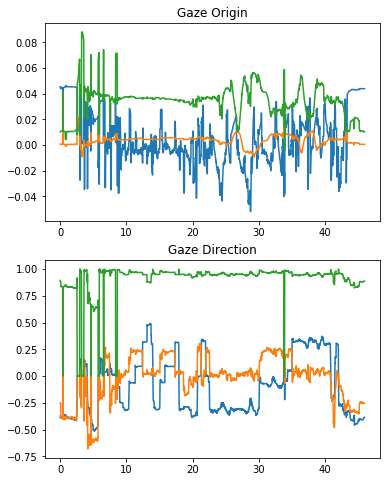

In [18]:
gaze_ix = stream_types.index('Gaze')
gaze_tvec = streams[gaze_ix]['time_stamps']

nominal_srate = float(streams[gaze_ix]['info']['nominal_srate'][0])
est_srate = 1 / np.median(np.diff(gaze_tvec))
print(f"Nominal srate: {nominal_srate:.3f} Hz\tEst. Srate: {est_srate:.3f} Hz")

chan_labels = [_['label'][0] for _ in streams[gaze_ix]['info']['desc'][0]['channels'][0]['channel']]
print(chan_labels)

b_gaze_origin = [_.startswith('GazeRayOrigin') for _ in chan_labels]
gaze_origin_dat = streams[gaze_ix]['time_series'][:, b_gaze_origin]
b_gaze_dir = [_.startswith('GazeRayDirection') for _ in chan_labels]
gaze_dir_dat = streams[gaze_ix]['time_series'][:, b_gaze_dir]

b_valid = streams[gaze_ix]['time_series'][:, chan_labels.index('GazeRayIsValid')] > 0

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(gaze_tvec[b_valid] - gaze_tvec[0], gaze_origin_dat[b_valid])
plt.title('Gaze Origin')
plt.subplot(2, 1, 2)
plt.plot(gaze_tvec[b_valid] - gaze_tvec[0], gaze_dir_dat[b_valid])
plt.title('Gaze Direction')
plt.show()

## Get the raw head pose data

Nominal srate: 72.000 Hz	Est. Srate: 71.819 Hz
['PosX', 'PosY', 'PosZ', 'RotW', 'RotX', 'RotY', 'RotZ']


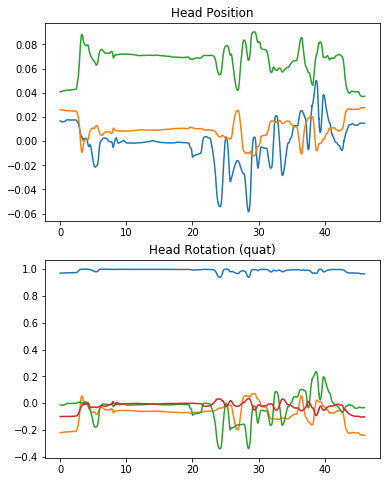

In [19]:
mocap_ix = stream_types.index('MoCap')
mocap_tvec = streams[mocap_ix]['time_stamps']

nominal_srate = float(streams[mocap_ix]['info']['nominal_srate'][0])
est_srate = 1 / np.median(np.diff(mocap_tvec))
print(f"Nominal srate: {nominal_srate:.3f} Hz\tEst. Srate: {est_srate:.3f} Hz")

chan_labels = [_['label'][0] for _ in streams[mocap_ix]['info']['desc'][0]['channels'][0]['channel']]
print(chan_labels)

b_pos = [_.startswith('Pos') for _ in chan_labels]
pos_dat = streams[mocap_ix]['time_series'][:, b_pos]

b_rot = [_.startswith('Rot') for _ in chan_labels]
rot_dat = streams[mocap_ix]['time_series'][:, b_rot]

plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(mocap_tvec - mocap_tvec[0], pos_dat)
plt.title('Head Position')
plt.subplot(2, 1, 2)
plt.plot(mocap_tvec - mocap_tvec[0], rot_dat)
plt.title('Head Rotation (quat)')
plt.show()

## Plot head pose and gaze origin->direction in 3D plot.

Note that in these plots we swap the y- and z-data, simply because matplotlib makes it difficult to use arbitrary coordinate systems; +z is horizontal straight away from the face in Unity but vertical up in MPL.

In [113]:
from scipy.spatial.transform import Rotation as R


r = R.from_quat(np.roll(rot_dat, -1, axis=1))
head_dir = r.apply([0, 0, 1])
head_end = pos_dat + head_dir

gaze_3d = np.stack((gaze_origin_dat, gaze_dir_dat))

Text(0.5, 0.92, 'PicoNeo2Eye with LSL (blue=head, red=gaze)')

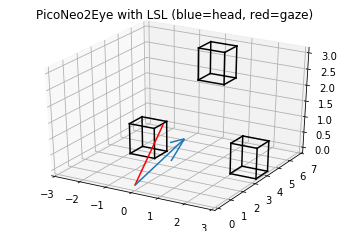

In [114]:
import itertools

plot_time = 15
gaze_scale = 6.0
q_length = 4.0

cube_centers = [[0, 6.51, 2.38],
                [-2, 5, 0],
                [2, 5, 0]]
d = 1.0
r = [-d/2, d/2]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-0.1, 7.0])
ax.set_zlim([-0.1, 3.1])

norm_gaze_vec = np.linalg.norm(gaze_3d[1] - gaze_3d[0], axis=-1, keepdims=True)
gaze_3d[1] = gaze_3d[0] + gaze_scale * (gaze_3d[1] / norm_gaze_vec)

for cube_ix, cu_xyz in enumerate(cube_centers):
    for s, e in itertools.combinations(np.array(list(itertools.product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            ax.plot3D(*zip(cu_xyz + s, cu_xyz + e), color="k")

head_time_ix = np.argmin(np.abs((mocap_tvec - mocap_tvec[0] - plot_time)))
Q = ax.quiver3D(pos_dat[head_time_ix, 0], pos_dat[head_time_ix, 2], pos_dat[head_time_ix, 1],
                head_end[head_time_ix, 0], head_end[head_time_ix, 2], head_end[head_time_ix, 1],
                length=q_length, normalize=True)

gaze_time_ix = np.argmin(np.abs((gaze_tvec - mocap_tvec[0] - plot_time)))
L, = ax.plot(gaze_3d[:, gaze_time_ix, 0], gaze_3d[:, gaze_time_ix, 2], gaze_3d[:, gaze_time_ix, 1], 'r')
ax.set_title('PicoNeo2Eye with LSL (blue=head, red=gaze)')

In [115]:
step_interval = 1/60
mov_dur = 30
frames = int(mov_dur / step_interval)
start_time = 10.0

def update(step):
    global Q
    Q.remove()
    
    head_ix = np.argmin(np.abs((mocap_tvec - mocap_tvec[0] - start_time) - step * step_interval))
    Q = ax.quiver3D(pos_dat[head_ix, 0], pos_dat[head_ix, 2], pos_dat[head_ix, 1],
                    head_end[head_ix, 0], head_end[head_ix, 2], head_end[head_ix, 1],
                    length=q_length, normalize=True)
    
    gaze_ix = np.argmin(np.abs(gaze_tvec - mocap_tvec[head_ix]))
    L.set_data(gaze_3d[:, gaze_ix, 0], gaze_3d[:, gaze_ix, 2])
    L.set_3d_properties(gaze_3d[:, gaze_ix, 1])
    

anim = FuncAnimation(fig, update, frames=np.arange(frames), interval=step_interval * 1000)
anim.save('piconeo2eye_lsl.mp4', dpi=80, writer='ffmpeg')
#Run from command line: ffmpeg -i piconeo2eye_lsl.mp4 -vf "fps=6,scale=640:-1:flags=lanczos" piconeo2eye_lsl.gif

## EEG Quality

In [35]:
eeg_ix = stream_types.index('EEG')
eeg_tvec = streams[eeg_ix]['time_stamps'] - mocap_tvec[0]
eeg_dat = streams[eeg_ix]['time_series']

nominal_srate = float(streams[eeg_ix]['info']['nominal_srate'][0])
est_srate = 1 / np.median(np.diff(eeg_tvec))
print(f"Nominal srate: {nominal_srate:.3f} Hz\tEst. Srate: {est_srate:.3f} Hz")

chan_labels = [_['label'][0] for _ in streams[eeg_ix]['info']['desc'][0]['channels'][0]['channel']]
print(chan_labels)

Nominal srate: 512.000 Hz	Est. Srate: 511.979 Hz
['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'FCz', 'CP3', 'FC3', 'TP7', 'FPz', 'FT7', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'CPz', 'CP4', 'FC4', 'TP8', 'Oz', 'FT8']


In [43]:
nohmd_streams, nohmd_header = pyxdf.load_xdf('test_eeg.xdf')
for strm in nohmd_streams:
    print(f"Found stream {strm['info']['name'][0]} ({strm['info']['type'][0]}) with data shape "
          f"{np.array(strm['time_series']).shape}")

nohmd_stream_types = [strm['info']['type'][0] for strm in nohmd_streams]
nohmd_stream_ix = nohmd_stream_types.index('EEG')
nohmd_eeg_tvec = nohmd_streams[nohmd_stream_ix]['time_stamps']
nohmd_eeg_tvec -= nohmd_eeg_tvec[0]
nohmd_eeg_dat = nohmd_streams[nohmd_stream_ix]['time_series']
nohmd_chan_labels = [_['label'][0]
                     for _ in nohmd_streams[nohmd_stream_ix]['info']['desc'][0]['channels'][0]['channel']]

Found stream UB-2015.05.10 (EEG) with data shape (18440, 31)


Text(0.5, 1.0, 'HMD-')

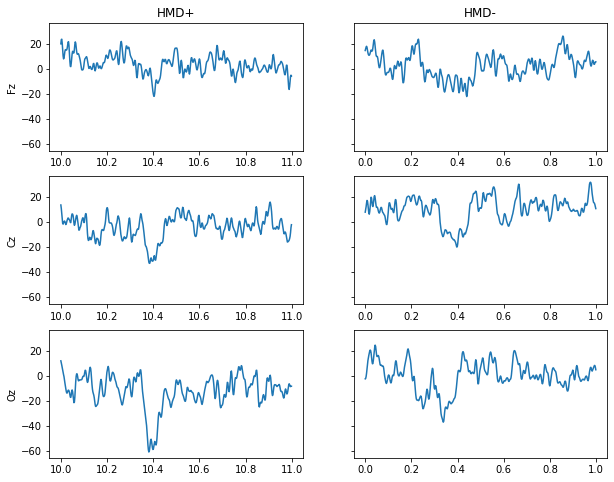

In [66]:
t_start, t_stop = 10, 11
b_eeg = np.logical_and(eeg_tvec >= t_start, eeg_tvec < t_stop)
b_nohmd = nohmd_eeg_tvec < (t_stop - t_start)

plt_chans = ['Fz', 'Cz', 'Oz']

fig, axes = plt.subplots(len(plt_chans), 2, figsize=(10, 8), sharey=True)
for ch_ix, ch_lab in enumerate(plt_chans):
    axes[ch_ix, 0].plot(eeg_tvec[b_eeg], eeg_dat[b_eeg, chan_labels.index(ch_lab)])
    axes[ch_ix, 0].set_ylabel(ch_lab)
    axes[ch_ix, 1].plot(nohmd_eeg_tvec[b_nohmd], nohmd_eeg_dat[b_nohmd, nohmd_chan_labels.index(ch_lab)])

axes[0, 0].set_title('HMD+')
axes[0, 1].set_title('HMD-')

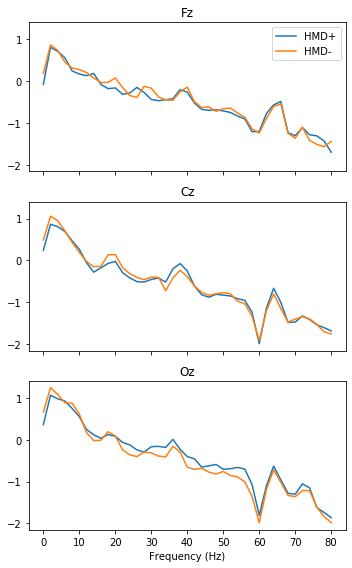

In [71]:
from scipy import signal

t_start, t_stop = 10, 20
b_eeg = np.logical_and(eeg_tvec >= t_start, eeg_tvec < t_stop)
b_nohmd = nohmd_eeg_tvec < (t_stop - t_start)

f_lim = 80

fig, axes = plt.subplots(len(plt_chans), 1, figsize=(5, 8), sharex=True, sharey=True)
for ch_ix, ch_lab in enumerate(plt_chans):
    freqs, Pxx = signal.welch(eeg_dat[b_eeg, chan_labels.index(ch_lab)], fs=nominal_srate)
    b_freqs = freqs <= f_lim
    axes[ch_ix].plot(freqs[b_freqs], np.log10(Pxx[b_freqs]), label='HMD+')
    
    freqs, Pxx = signal.welch(nohmd_eeg_dat[b_nohmd, nohmd_chan_labels.index(ch_lab)], fs=nominal_srate)
    b_freqs = freqs <= f_lim
    axes[ch_ix].plot(freqs[b_freqs], np.log10(Pxx[b_freqs]), label='HMD-')
    axes[ch_ix].set_title(ch_lab)
    
axes[0].legend()
axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()